# Forward Modeling of an Emission Spectrum using the MODIT Cross Section

Update November 23rd (2022); Septempber 3rd (2021) Hajime Kawahara

We try to compute an emission spectrum in which many methane lines exist. 

In [1]:
from exojax.spec import rtransfer as rt
from exojax.opacity import modit

In [2]:
#ATMOSPHERE                                                                     
NP=100
T0=400.0 #K
Parr, dParr, k=rt.pressure_layer(NP=NP)
Tarr = T0*(Parr)**0.03

A T-P profile we assume is here.

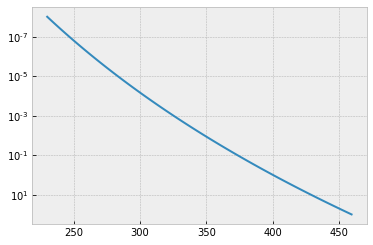

In [3]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.plot(Tarr,Parr)
plt.yscale("log")
plt.gca().invert_yaxis()
plt.show()

We set a wavenumber grid using wavenumber_grid. Specify xsmode="modit" though it is not mandatory.
MODIT uses FFT, so the (internal) wavenumber grid should be evenly spaced in log. 

In [4]:
from exojax.utils.grids import wavenumber_grid
nus,wav,resolution=wavenumber_grid(16360,16560,10000,unit="AA",xsmode="modit")

xsmode assumes ESLOG in wavenumber space: mode=modit


Loading a molecular database of CH4 and CIA (H2-H2)... 

In [5]:
from exojax.spec import api, contdb
mdbCH4=api.MdbExomol('.database/CH4/12C-1H4/YT10to10/',nus,crit=1.e-30, Ttyp=300)
cdbH2H2=contdb.CdbCIA('.database/H2-H2_2011.cia',nus)

Background atmosphere:  H2
Reading .database/CH4/12C-1H4/YT10to10/12C-1H4__YT10to10__06000-06100.trans.bz2
Reading .database/CH4/12C-1H4/YT10to10/12C-1H4__YT10to10__06100-06200.trans.bz2
.broad is used.
Broadening code level= a1
default broadening parameters are used for  12  J lower states in  29  states
H2-H2


We have 0.14 million lines

In [6]:
len(mdbCH4.A)

144762

This number is not too large for MODIT. Maybe it works. If not or for a larger number, consider to use PreMODIT.

In [7]:
from exojax.spec import molinfo
molmassCH4=molinfo.molmass("CH4")

Computing the relative partition function, 

In [8]:
from jax import vmap
qt=vmap(mdbCH4.qr_interp)(Tarr)

Pressure and Natural broadenings 

In [9]:
from jax import jit
from exojax.spec.exomol import gamma_exomol
from exojax.spec import gamma_natural

gammaLMP = jit(vmap(gamma_exomol,(0,0,None,None)))\
        (Parr,Tarr,mdbCH4.n_Texp,mdbCH4.alpha_ref)
gammaLMN=gamma_natural(mdbCH4.A)
gammaLM=gammaLMP+gammaLMN[None,:]

And line strength

In [10]:
from exojax.spec import SijT
SijM=jit(vmap(SijT,(0,None,None,None,0)))\
    (Tarr,mdbCH4.logsij0,mdbCH4.nu_lines,mdbCH4.elower,qt)

MODIT uses the normalized quantities by wavenumber/R, where R is the spectral resolution. In this case, the normalized Doppler width (nsigmaD) is common for the same isotope. Then, we use a 2D DIT grid with the normalized gammaL and q = R log(nu).

In [12]:
from exojax.spec import normalized_doppler_sigma
import numpy as np
nsigmaDl=normalized_doppler_sigma(Tarr,molmassCH4,resolution)[:,np.newaxis]

In [13]:
dv_lines=mdbCH4.nu_lines/resolution
ngammaLM=gammaLM/dv_lines

MODIT uses a grid of ngammaL and wavenumber. dgmatrix makes a 1D grid for ngamma for n-th layers.

In [14]:
dgm_ngammaL=modit.dgmatrix(ngammaLM,0.2)

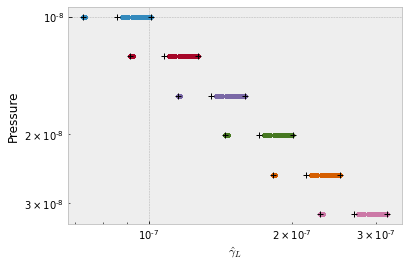

In [15]:
#show the DIT grids 
from exojax.plot.ditplot import plot_dgmn
plot_dgmn(Parr,dgm_ngammaL,ngammaLM,0,6)

We need to precompute the contribution for wavenumber and pmarray. These can be computed using init_dit. 

In [16]:
from exojax.opacity import initspec 
cnu,indexnu,R,pmarray=initspec.init_modit(mdbCH4.nu_lines,nus)

Let's compute a cross section matrix using modit.xsmatrix.

In [17]:
xsm=modit.xsmatrix(cnu,indexnu,R,pmarray,nsigmaDl,ngammaLM,SijM,nus,dgm_ngammaL)

/tmp/ipykernel_8613/2860296713.py:4: RuntimeWarning: invalid value encountered in log10
  c=plt.imshow(np.log10(xsm),cmap="bone_r",vmin=-23,vmax=-19)


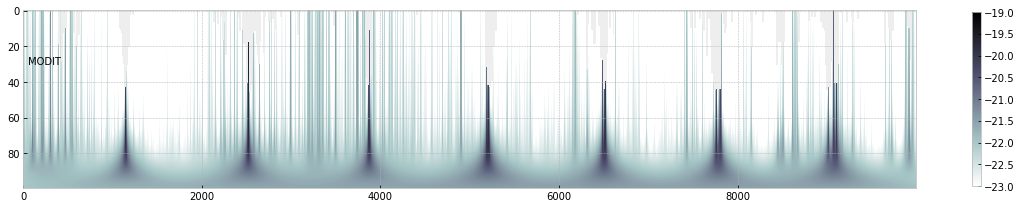

In [18]:
import numpy as np
fig=plt.figure(figsize=(20,4))
ax=fig.add_subplot(111)
c=plt.imshow(np.log10(xsm),cmap="bone_r",vmin=-23,vmax=-19)
plt.colorbar(c,shrink=0.8)
plt.text(50,30,"MODIT")
ax.set_aspect(0.2/ax.get_data_ratio())
plt.show()

Sometimes, xsm includes negative elements due to error. Check it.

In [19]:
len(xsm[xsm<0.0]), np.min(xsm)

(5470, DeviceArray(-5.3598605e-23, dtype=float32))

This negative value is very small. For instance, jnp.abs can remove it.

In [20]:
import jax.numpy as jnp
xsm=jnp.abs(xsm)

computing delta tau for CH4

In [21]:
from exojax.spec.rtransfer import dtauM
import jax.numpy as jnp
Rp=0.88
Mp=33.2
g=2478.57730044555*Mp/Rp**2 #gravity cm/s2
MMR=0.0059 #mass mixing ratio
dtaum=dtauM(dParr,xsm,MMR*np.ones_like(Tarr),molmassCH4,g)

computing delta tau for CIA

In [22]:
from exojax.spec.rtransfer import dtauCIA
mmw=2.33 #mean molecular weight
mmrH2=0.74
molmassH2=molinfo.molmass("H2")
vmrH2=(mmrH2*mmw/molmassH2) #VMR
dtaucH2H2=dtauCIA(nus,Tarr,Parr,dParr,vmrH2,vmrH2,\
            mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)

The total delta tau is a summation of them

In [23]:
dtau=dtaum+dtaucH2H2

you can plot a contribution function using exojax.plot.atmplot 

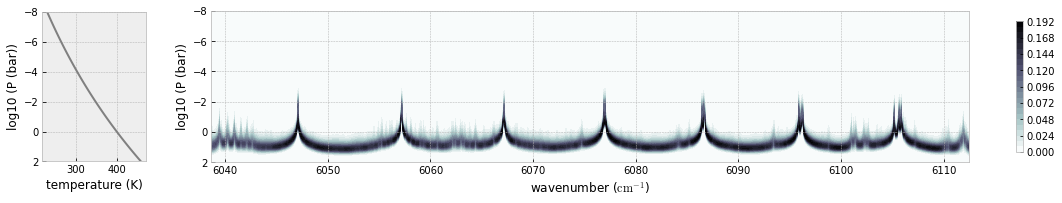

In [24]:
from exojax.plot.atmplot import plotcf
plotcf(nus,dtau,Tarr,Parr,dParr)
plt.show()

radiative transfering...

In [25]:
from exojax.spec import planck
from exojax.spec.rtransfer import rtrun
sourcef = planck.piBarr(Tarr,nus)
F0=rtrun(dtau,sourcef)

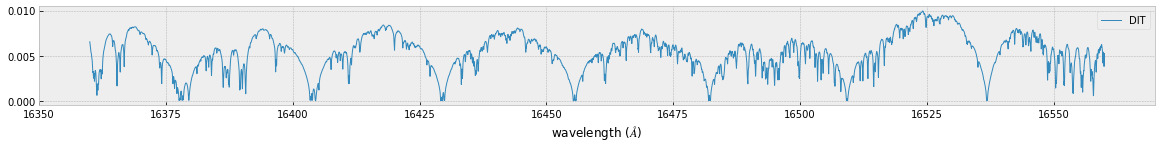

In [26]:
fig=plt.figure(figsize=(20,4))
ax=fig.add_subplot(211)
plt.plot(wav[::-1],F0,lw=1,label="MODIT")
plt.legend()
plt.xlabel("wavelength ($\AA$)")
plt.savefig("ch4.png")

MODIT uses ESLOG as the wavenunmber grid. We can directly apply the response to the raw spectrum.

In [27]:
#response and rotation settings 
from exojax.spec.response import ipgauss_sampling
from exojax.spec.spin_rotation import convolve_rigid_rotation
from exojax.utils.grids import velocity_grid
vsini_max = 100.0
vr_array = velocity_grid(resolution, vsini_max)


from exojax.utils.constants import c
import jax.numpy as jnp

wavd=jnp.linspace(16360,16560,1500) #observational wavelength grid
nusd = 1.e8/wavd[::-1]

RV=10.0 #RV km/s
vsini=20.0 #Vsini km/s
u1=0.0 #limb darkening u1
u2=0.0 #limb darkening u2

Rinst=100000. #spectral resolution of the spectrograph
beta=c/(2.0*np.sqrt(2.0*np.log(2.0))*Rinst) #IP sigma (STD of Gaussian)
Frot = convolve_rigid_rotation(F0, vr_array, vsini, u1, u2)
F = ipgauss_sampling(nusd, nus, Frot, beta, RV)


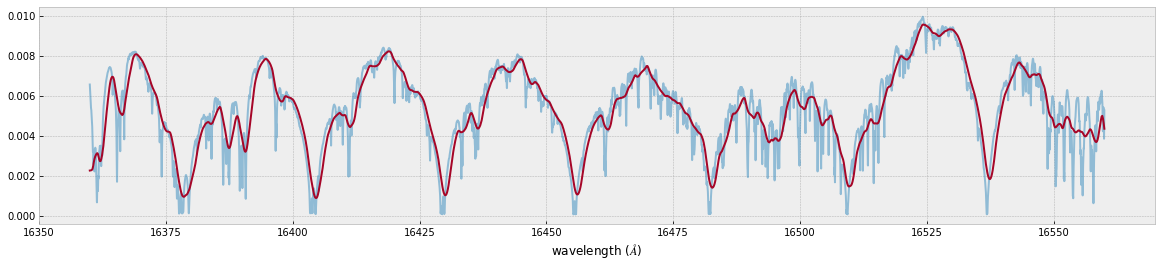

In [28]:
fig=plt.figure(figsize=(20,4))
plt.plot(wav[::-1],F0,alpha=0.5)
plt.plot(wavd[::-1],F)
plt.xlabel("wavelength ($\AA$)")
plt.savefig("moditCH4.png")

Let's save the spectrum for the retrieval.

In [29]:
np.savetxt("spectrum_ch4.txt",np.array([wavd,F]).T,delimiter=",")